In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
path = os.getcwd()
asc_folder = f'{path}\\asc_files'

# Status Quo

In [3]:
# moet worden aangepast naar het passende scenario
forcing = np.genfromtxt(f'{asc_folder}\\IMD_1975_2013.txt',  dtype=float, autostrip=True)

fertiliser = pd.read_csv('Fert_scen.csv')
fertiliser = fertiliser.replace(0, np.NaN) 


# moet worden aangepast naar het passende scenario
concentration_scen = pd.read_csv('Ctot_fert.csv')
concentration_scen

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
14240,3.803588,4.226209,4.648830,5.071451,5.494072,5.916693,6.339314,6.761935,7.184556,7.607177
14241,3.784233,4.204703,4.625174,5.045644,5.466114,5.886584,6.307055,6.727525,7.147995,7.568466
14242,3.764886,4.183207,4.601527,5.019848,5.438169,5.856489,6.274810,6.693131,7.111451,7.529772
14243,3.745549,4.161722,4.577894,4.994066,5.410238,5.826410,6.242582,6.658754,7.074927,7.491099


In [4]:
Fert_mean = np.zeros(10)
conc_mean = np.zeros(10)
for i in range(len(Fert_mean)):
    Fert_mean[i] = fertiliser.iloc[:, i].mean()
    conc_mean[i] = concentration_scen.iloc[:,i].mean()

print(Fert_mean)
print(conc_mean)

[174.26726031 193.63028924 212.99331816 232.35634708 251.71937601
 271.08240493 290.44543385 309.80846278 329.1714917  348.53452062]
[0.50723536 0.56359484 0.61995433 0.67631381 0.7326733  0.78903278
 0.84539226 0.90175175 0.95811123 1.01447072]


In [5]:
Ea = np.loadtxt('Ea_model_1.txt')
Ep = forcing[:, 2]
Qm = np.loadtxt('Qmodel_1.txt')


# amount of irrigation
frac1 = 0.5

beta_0 = 15
beta_1 = 0.25

Yo = 1000                # kg/ha without fertiliser
Yo_f = 3500              # extra kg/ha with fertiliser
Ky = 1                 # sensitivity to rainfall deficit
Fo = 20 * 10000 / 1000   # max kg fertiliser / ha / year
Kf = (Yo_f - Yo) / Fo    # kg coffee / kg fertiliser

Firr = Fert_mean
Frain = np.linspace(0, 0, 10)

prod_ppf = np.zeros(len(Frain))
E_s_ppf = np.zeros(len(Frain))
PPF = np.zeros(len(Frain))
Qgrey = np.zeros(len(Qm))

# c_0 = 0.05 # threshold value, needs be determined
c_0 = 0.6 # voor deze werkt het model
c_1 = conc_mean   # het lijkt er op dat onze concentraties een factor 10 te groot zijn
c_2 = conc_mean * 0.1 # voor deze werkt het model

print(conc_mean)

[0.50723536 0.56359484 0.61995433 0.67631381 0.7326733  0.78903278
 0.84539226 0.90175175 0.95811123 1.01447072]


In [6]:
for i in range(len(Frain)):
    # production
    Ya_rain= (Yo * (Ky * (1 - Ea/Ep) - 1) + (Yo_f * Frain[i]/Fo)) * (1-frac1)
    Ya_irr = (Yo + Yo_f * Firr[i]/Fo) * frac1
    production = Ya_rain + Ya_irr
    prod_ppf[i] = production.mean()
    
    # FSR
    if c_1[i] == 0:
        E_s = beta_0 * Qm ** beta_1
    else: 
        for j in range(len(Qm)):
            Qgrey[j] = min(max(0, (c_1[i]/c_0)*Qm[j] - Qm[j]), Qm[j])
        E_s = beta_0 * (Qm - Qgrey)**beta_1

        # E_s = beta_0 * (Qm - (c_0/c_1[i]) * Qm - Qm) ** beta_1
    E_s_ppf[i] = E_s.mean()

# deleting zero points
for i in range(len(E_s_ppf)):
    if E_s_ppf[i] == 0:
        E_s_ppf[i+1:] = np.nan
        prod_ppf[i+1:] = np.nan
    else:
        None 
        
prod_ppf_fin = prod_ppf[~np.isnan(prod_ppf)]
E_s_ppf_fin = E_s_ppf[~np.isnan(E_s_ppf)]

print('prod_ppf', len(prod_ppf))
print('prod_ppf_fin',len(prod_ppf_fin))
print('E_s_ppf',len(E_s_ppf))
print('E_s_ppf_fin',len(E_s_ppf_fin))


#fit curve
x = prod_ppf_fin
p = np.polyfit(prod_ppf_fin, E_s_ppf_fin, 2)
z = np.polyval(p, x)

print(p)

prod_ppf 10
prod_ppf_fin 10
E_s_ppf 10
E_s_ppf_fin 10
[-1.05758799e-06  3.37224213e-03  9.01912008e+00]


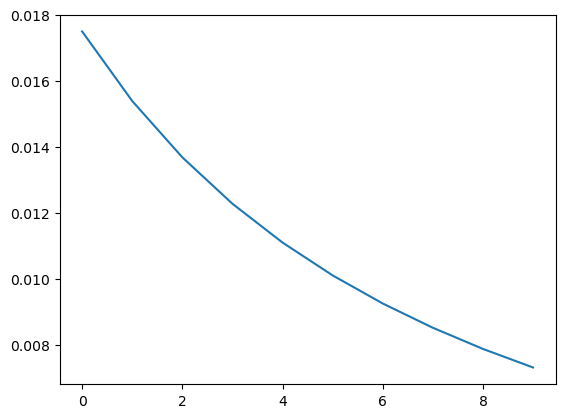

In [17]:
# Compute the derivative of the polynomial
# derivative_coeffs = np.polyder(p)
# derivative_coeffs
# z_test = np.polyval(derivative_coeffs, x)
# plt.plot(x,z_test)

# test = y *eta / x
# plt.plot(test)

In [15]:
# utility curve

xstar = prod_ppf[4]
ystar = np.polyval(p, xstar)

def exponential(x, a, b,c):
    y_ans = a * np.exp(-b*x) + c 
    return y_ans

x = np.linspace(0.001, 6000, 100)
y = np.linspace(0.001, 10, 100)

# (a, b, c), cov = curve_fit(exponential, prod_ppf, E_s_ppf, p0 = [0, 0.000001, 0])

# ppf_fit = exponential(x, a, b ,c)

                           

eta = - ystar / (2 * p[0] * xstar ** 2 + p[1] * xstar)
Umax = np.log(xstar) + eta * np.log(ystar)

x = prod_ppf
y = np.exp(1/eta * (Umax - np.log(x)))

eta
y
# Eta is 

array([12.46739165, 12.01613277, 11.61706876, 11.26064426, 10.93960639,
       10.64833422, 10.38239304, 10.13822936,  9.91295677,  9.7042024 ])

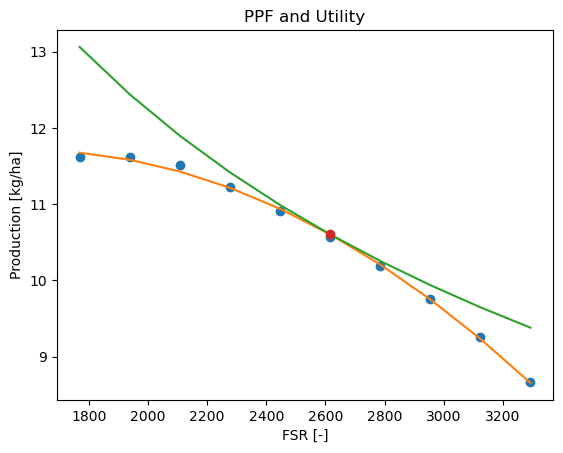

In [8]:
plt.figure()
plt.plot(prod_ppf, E_s_ppf, 'o', label = 'values')
plt.plot(x, z, label = 'fitted curve')
plt.plot(x, y, label = 'utility')
plt.plot(xstar, ystar, 'o', label = 'status qua')
plt.title('PPF and Utility')
plt.ylabel('Production [kg/ha]')
plt.xlabel('FSR [-]');

# Scenario 2

In [19]:
# moet worden aangepast naar het passende scenario
forcing_2=np.loadtxt('forcing_2.txt')

# moet worden aangepast naar het passende scenario
concentration_scen = pd.read_csv('Ctot_fert_2.csv')
concentration_scen

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
14240,3.803588,4.226209,4.648830,5.071451,5.494072,5.916693,6.339314,6.761935,7.184556,7.607177
14241,3.784233,4.204703,4.625174,5.045644,5.466114,5.886584,6.307055,6.727525,7.147995,7.568466
14242,3.764886,4.183207,4.601527,5.019848,5.438169,5.856489,6.274810,6.693131,7.111451,7.529772
14243,3.745549,4.161722,4.577894,4.994066,5.410238,5.826410,6.242582,6.658754,7.074927,7.491099


In [21]:
conc_mean_2 = np.zeros(10)

for i in range(len(conc_mean_2)):
    conc_mean_2[i] = concentration_scen.iloc[:,i].mean()

print(Fert_mean)
print(conc_mean_2)

[174.26726031 193.63028924 212.99331816 232.35634708 251.71937601
 271.08240493 290.44543385 309.80846278 329.1714917  348.53452062]
[0.50723536 0.56359484 0.61995433 0.67631381 0.7326733  0.78903278
 0.84539226 0.90175175 0.95811123 1.01447072]


In [ ]:
Ea = np.loadtxt('Ea_model_2.txt')
Ep = forcing[:, 2]
Qm = np.loadtxt('Qmodel_1.txt')


# amount of irrigation
frac1 = 0.5

beta_0 = 15
beta_1 = 0.25

Yo = 1000                # kg/ha without fertiliser
Yo_f = 3500              # extra kg/ha with fertiliser
Ky = 1                 # sensitivity to rainfall deficit
Fo = 20 * 10000 / 1000   # max kg fertiliser / ha / year
Kf = (Yo_f - Yo) / Fo    # kg coffee / kg fertiliser

Firr = Fert_mean
Frain = np.linspace(0, 0, 10)

prod_ppf = np.zeros(len(Frain))
E_s_ppf = np.zeros(len(Frain))
PPF = np.zeros(len(Frain))
Qgrey = np.zeros(len(Qm))

# c_0 = 0.05 # threshold value, needs be determined
c_0 = 0.6 # voor deze werkt het model
c_1 = conc_mean   # het lijkt er op dat onze concentraties een factor 10 te groot zijn
c_2 = conc_mean * 0.1 # voor deze werkt het model

print(conc_mean)